# Further analysis of BERT

This notebook is not tested and not guaranteed it will work for you. Though the structure is similar to 07_BERT_embeddings notebook, the results of this notebook are not used anywhere, so this notebook is also not documented.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
from transformers import (BertModel, 
                          BertTokenizer)

from tqdm.notebook import tqdm

Read the data

In [3]:
data = pd.read_csv("dataset/data.csv", sep = ";")
data.head()

,text,label
0,fucks sake go away stupid anon — ^ https://t....,abusive
1,Damn dean just put Corbin to sleep. That Match...,abusive
2,@TheRealCamerota THAT BEER BUYING FREAKING IDI...,abusive
3,what idiot called them antacids and not afterb...,abusive
4,RT @gogglepossum: Don't you hate people that p...,abusive


In [4]:
sel = ["vulgar", "profane", "obscene", "abusive"]
data = data[data["label"].isin(sel)]
data

,text,label
0,fucks sake go away stupid anon — ^ https://t....,abusive
1,Damn dean just put Corbin to sleep. That Match...,abusive
2,@TheRealCamerota THAT BEER BUYING FREAKING IDI...,abusive
3,what idiot called them antacids and not afterb...,abusive
4,RT @gogglepossum: Don't you hate people that p...,abusive
...,...,...
44752,Fat piece of shit you obese piece of shit. I t...,obscene
44753,FUCKING FAGGOT LOLWAT.,obscene
44754,""" our previous conversation you fucking shit e...",obscene
44755,Your absurd edits Your absurd edits on great w...,obscene


Preprocess the dataset

In [5]:
def preprocess(A, labels):
    B = []
    labels_new = []
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)
        
        # remove numbers
        text = text.replace("[0-9]", " ")
    
        # to lower case
        text = text.lower()

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        labels_new.append(labels[i])
    return B, labels_new

In [6]:
texts, labels = preprocess(data["text"].tolist(), data["label"].tolist())
len(texts)

13420

In [7]:
bert_model = BertModel.from_pretrained("bert-base-cased", output_hidden_states = True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [9]:
tokenized_labels = dict()
max_length = 0
for label in list(set(labels)):
    tokenized_labels[label] = bert_tokenizer.tokenize(f" - This is {label}")
    if len(tokenized_labels[label]) > max_length:
        max_length = len(tokenized_labels[label])

    
print(max_length)
tokenized_labels
    


6


{'abusive': ['-', 'This', 'is', 'abusive'],
 'profane': ['-', 'This', 'is', 'pro', '##fan', '##e'],
 'obscene': ['-', 'This', 'is', 'o', '##bs', '##cene']}

In [10]:
tokenized_labels_lengths = dict()
for label in list(set(labels)):
    tokenized_labels_lengths[label] = len(tokenized_labels[label][3:])
    
tokenized_labels_lengths

{'abusive': 1, 'profane': 3, 'obscene': 3}

In [11]:
texts_new = []
for i, text in enumerate(texts):
    texts_new.append(f"{text} - This is {labels[i]}")

In [12]:
texts_new[0:10]

['fucks sake go away stupid anon — ^   - This is abusive',
 'damn dean just put corbin to sleep. that match also showed why it was on pre show. boring as fuck - This is abusive',
 ' that beer buying freaking idiot thinks trump leaked it to nail rice? are you kidding? and sacrifice flynn. mud is appropo - This is abusive',
 'what idiot called them antacids and not afterburners - This is abusive',
 " don't you hate people that put salt on their bag of dicks before even trying them? - This is abusive",
 'you worried about somebody bein ugly... bitch you ugly... - This is abusive',
 'holy crap!! the biggest assclown of a mayor on  pulling race card!! get his ass outta office!!! draintheswamp - This is abusive',
 ' i just want to cry so fucking bad look at them  - This is abusive',
 'yooooo vans got these sick ass velvet oxblood slip onnnnssssss 💦💦💦💦👅👅👅👅 - This is abusive',
 ' disgusting. insulting. parks are not a charity. give them a fucking budget, asshole.  theresistance… - This is abus

How many sequences are too long to add the label sentence?

In [13]:
pad_token=0
pad_token_segment_id=0
max_length=512

def convert_to_input(reviews):
  input_ids,attention_masks,token_type_ids, nums=[],[],[],[]
  
  for x in tqdm(reviews,position=0, leave=True):
    inputs = bert_tokenizer.encode_plus(x,add_special_tokens=True, max_length=max_length, return_overflowing_tokens=True)
    
    i, t, num = inputs["input_ids"], inputs["token_type_ids"], inputs["num_truncated_tokens"]
    m = [1] * len(i)
            
    padding_length = max_length - len(i)

    i = i + ([pad_token] * padding_length)
    m = m + ([0] * padding_length)
    t = t + ([pad_token_segment_id] * padding_length)
    
    input_ids.append(i)
    attention_masks.append(m)
    token_type_ids.append(t)
    nums.append(num)
  
  return [np.asarray(input_ids), 
            np.asarray(attention_masks), 
            np.asarray(token_type_ids),
            np.asarray(nums)]

In [14]:
test = convert_to_input(texts)

  0%|          | 0/13420 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Remove truncated sentences as we lose the labes

In [15]:
idx = np.array(test[3]) <= 0

In [16]:
inputs = np.array(test[0:3])
inputs = inputs[:, idx, :]
inputs.shape

(3, 13221, 512)

In [17]:
labels = np.array(labels)
labels = labels[idx]
len(labels)

13221

In [18]:
#token_embeddings = torch.stack(hidden_states, dim=0)
import tensorflow as tf
import torch

embeddings = []

bert_model = bert_model.to("cuda")
for j in tqdm(range(inputs.shape[1])):
#with torch.no_grad():
    inputs1 = torch.tensor(inputs[:,j,:])
    inputs1 = inputs1.to("cuda")
    inputs1 = inputs1.long()

    output = bert_model(inputs1)
    hidden_states = output.hidden_states

    token_embeddings = torch.stack(hidden_states, dim= 0)[:, 0, :, :]
    token_embeddings = token_embeddings.cpu()

    tokens = []
    
    # obtain location of the label tokens
    last = sum(inputs[1,j,:]) - 1 # -1 to exclude the [SEP] symbol
    first = last - tokenized_labels_lengths[labels[j]]
    
    # get embeddings by summing last 4 layers
    for i in range(token_embeddings.shape[1]):
        tokens.append(np.sum(token_embeddings[-4:, i, :].detach().numpy(), axis = 0))
    
    # after obtaining embeddings for 512 tokens, average those that belong to label
    tokens = np.array(tokens)
    tokens = tokens[first:last, :]
    tokens = np.mean(tokens, axis = 0)
    embeddings.append(tokens)

  0%|          | 0/13221 [00:00<?, ?it/s]

C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\matij\anaconda3\envs\nlp-test\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [39]:
test = np.array(embeddings)
test.shape

(13221, 768)

In [40]:
#np.savez_compressed("embeddings", embeddings=test)

Import the model

In [41]:
#test = np.load("embeddings.npz")
#test = test["embeddings"]
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('bert-base-nli-mean-tokens', 'cuda')

#model = SentenceTransformer('distilbert-base-nli-mean-tokens', "cuda")

#model.max_seq_length = 512

In [42]:
#ids = np.random.choice(list(range(len(texts))), size = 57581)
#ids = np.arange(0, len(labels))
#ids = np.sort(ids)
#l = np.array(labels)[ids]
#t = np.array(texts)[ids]
#ids = np.argsort(l)
#l = l[ids]
#t = t[ids]
#l
idx = np.argsort(labels)
labels = labels[idx]
sentence_embeddings = test[idx, :]

In [43]:
#texts

In [44]:
#sentences = ['This framework generates embeddings for each input sentence',
#    'Sentences are passed as a list of string.', 
#    'The quick brown fox jumps over the lazy dog.']
#sentence_embeddings = model.encode(t, show_progress_bar = True)
#
#print("Sentence embeddings:")
#print(sentence_embeddings)
print(sentence_embeddings)

[[-4.593318   -5.7181816  -0.5780396  ... -5.6984506   0.8760278
   4.9951053 ]
 [-0.24070968 -9.172941   -1.3749347  ... -7.2372622  -0.27863434
  -1.1878853 ]
 [ 1.4915609  -5.2982073  -0.43185684 ... -7.1250105   1.7600458
   0.17899188]
 ...
 [-1.4070283  -5.2441783   0.9575899  ... -6.3583694   0.3097835
   4.903381  ]
 [ 0.35112634  1.4694649  -0.8964603  ... -1.7242912   1.1959769
   2.736201  ]
 [-2.187752   -2.1805997  -1.2442788  ... -6.0393767   0.20209129
   1.3893461 ]]


In [45]:
idx = np.isnan(sentence_embeddings).any(axis = 1)
sentence_embeddings = sentence_embeddings[~idx]
labels = labels[~idx]

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# calculate distance between every embedding pair
sim_mat = cosine_similarity(sentence_embeddings, sentence_embeddings)
#df['sim_score'] = sim_mat[sentence_id]
print(sim_mat.shape)

(13215, 13215)


In [47]:
#fig, ax = plt.subplots(figsize=(20,20))
#cax = ax.matshow(sim_mat, interpolation='nearest',cmap=plt.get_cmap("PiYG", 7))
#plt.show()

In [48]:
#test = np.array(labels)[ids]
#test[380]

In [49]:
l = labels

In [50]:
score = {}
for i in range(len(l)):
    x = score.get(l[i])
    if x is None:
        x = []
    x.append(sim_mat[100,i])
    score[l[i]] = x

In [51]:
for k,v in score.items():
    print(f"{k}:{sum(v)/len(v)}")

abusive:0.45411904294306027
obscene:0.49268211421999825
profane:0.4998234525795967


In [52]:
labs, occ = np.unique(l, return_counts = True)
occ

array([4219, 8240,  756], dtype=int64)

In [53]:
print(l)
print(labs)

['abusive' 'abusive' 'abusive' ... 'profane' 'profane' 'profane']
['abusive' 'obscene' 'profane']


In [54]:
indices = np.cumsum(occ)
indices = np.insert(indices, 0, 0)
indices

array([    0,  4219, 12459, 13215], dtype=int64)

In [55]:
new_m = np.zeros((len(occ), len(occ)))
for i in range(len(indices)-1):
    for j in range(len(indices)-1):
        x = indices[i]
        y = indices[j]
        x1 = indices[i+1]
        y1 = indices[j+1]
        
        #print(f"{x},{y},{x1},{y1}")
        new_m[i,j] = np.mean(sim_mat[int(x):int(x1), int(y):int(y1)])

In [56]:
df = pd.DataFrame(new_m, columns = labs, index = labs)
df

,abusive,obscene,profane
abusive,0.553272,0.551695,0.550011
obscene,0.551695,0.594917,0.594426
profane,0.550011,0.594426,0.595553


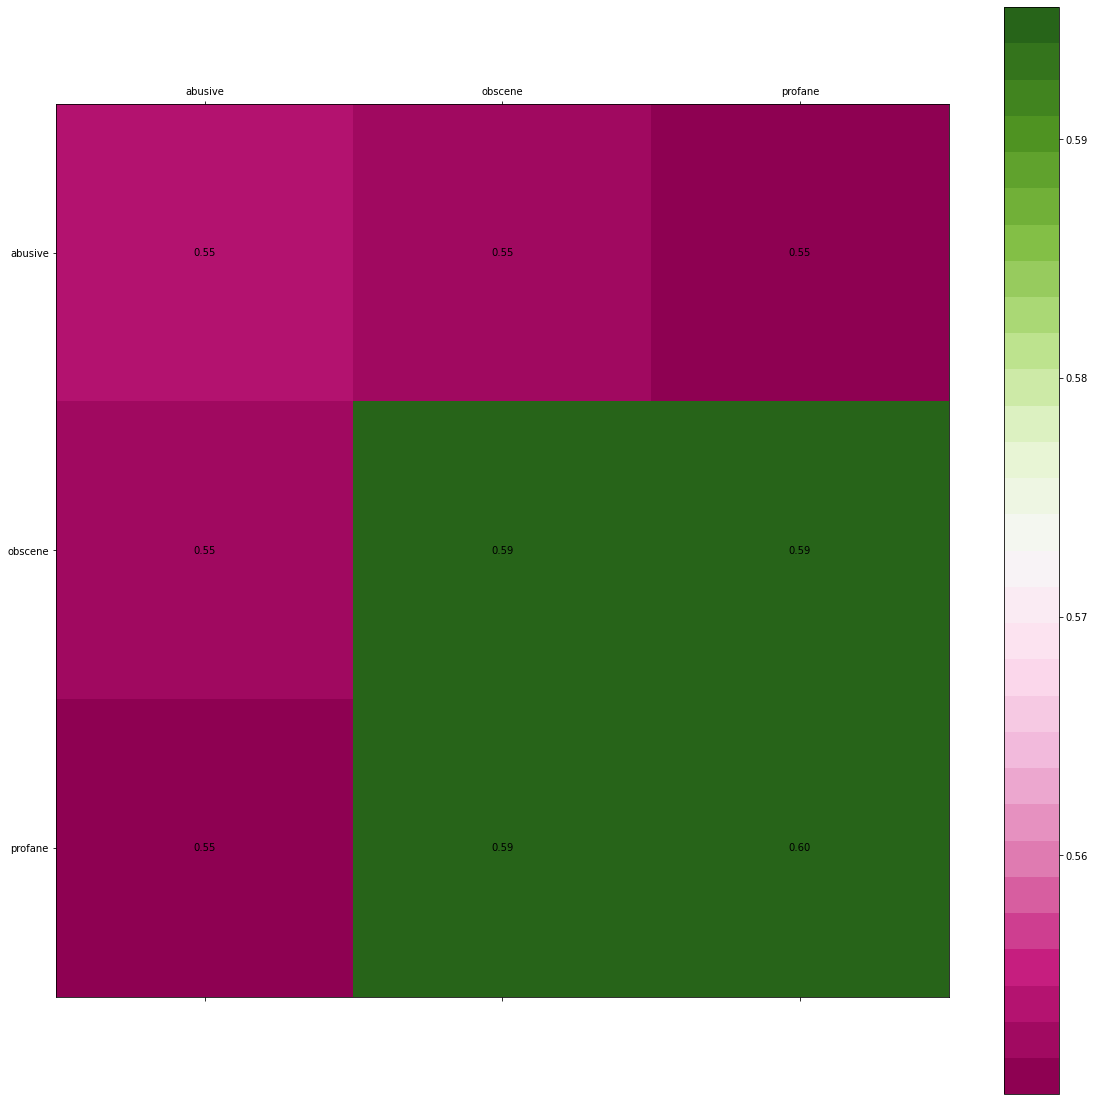

In [57]:
fig, ax = plt.subplots(figsize=(20,20))
cax = ax.matshow(df, interpolation='nearest',cmap=plt.get_cmap("PiYG", 30))

for i in range(new_m.shape[0]):
    for j in range(new_m.shape[0]):
        c = new_m[j,i]
        ax.text(i, j, f"{c:.2f}", va='center', ha='center')

fig.colorbar(cax)

ax.set_xticks(np.arange(len(labs)))
ax.set_yticks(np.arange(len(labs)))
ax.set_xticklabels(labs.tolist())
ax.set_yticklabels(labs.tolist())
plt.show()

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
mask = np.triu(np.ones_like(new_m), k = 1)
sns.heatmap(df, cmap="YlGnBu", annot=True, mask=mask, ax = ax, vmin=0, vmax=1)
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [59]:
import torch
print(torch.cuda.is_available())

True


In [60]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [61]:
#!pip uninstall -y torch

In [62]:
indices

array([    0,  4219, 12459, 13215], dtype=int64)

In [63]:
avgs = []
for i in range(len(indices) - 1):
    avgs.append(np.mean(sentence_embeddings[indices[i]:indices[i+1]], axis = 0))

In [64]:
df1 = pd.DataFrame(cosine_similarity(avgs, avgs), columns = labs, index = labs)
df1

,abusive,obscene,profane
abusive,1.000000,0.962430,0.959401
obscene,0.962430,1.000000,0.998711
profane,0.959401,0.998711,1.000000


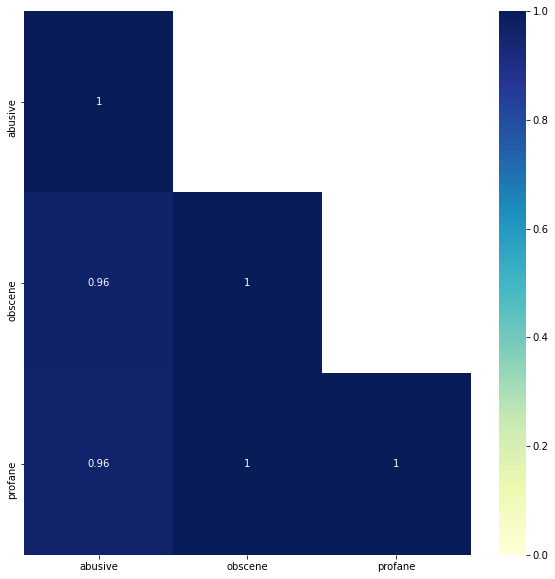

In [66]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
mask = np.triu(np.ones_like(new_m), k = 1)
sns.heatmap(df1, cmap="YlGnBu", annot=True, mask=mask, ax = ax, vmin=0, vmax=1)
plt.show()

TODO: Visualize embeddings

In [67]:
len(labels)
from sklearn.manifold import TSNE
import matplotlib.cm as cm


In [68]:
def plotTSNE(title, embedding_clusters, labels, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    print(embedding_clusters.shape)
    n, m = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters)
    embeddings_en_2d = np.array(model_en_2d)
    print(embeddings_en_2d.shape)
    plot_similar_words(title, labels, embeddings_en_2d, filename)

In [69]:
def plot_similar_words(title, labels, embedding_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    #colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
    #colors = dict(zip(list(set(labels)), colors))
    #print(colors)
    colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
    #colors = cm.tab20(np.linspace(0, 1, len(set(labels))))
    plt.set_cmap("rainbow")
    for i, label in enumerate(set(labels)):
        idx = np.where(labels == label)
        x = embedding_clusters[idx, 0]
        y = embedding_clusters[idx, 1]
        plt.scatter(x, y, alpha=0.7, label=label, s = 2, color = colors[i])
        #plt.scatter(int(np.mean(x)), int(np.mean(y)), marker='s', edgecolor='black', linewidth=3, facecolor=colors[i])
        plt.annotate(label.upper(), alpha=1.0, xy=(int(np.mean(x)), int(np.mean(y))), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=12)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

(13215, 768)
(13215, 2)


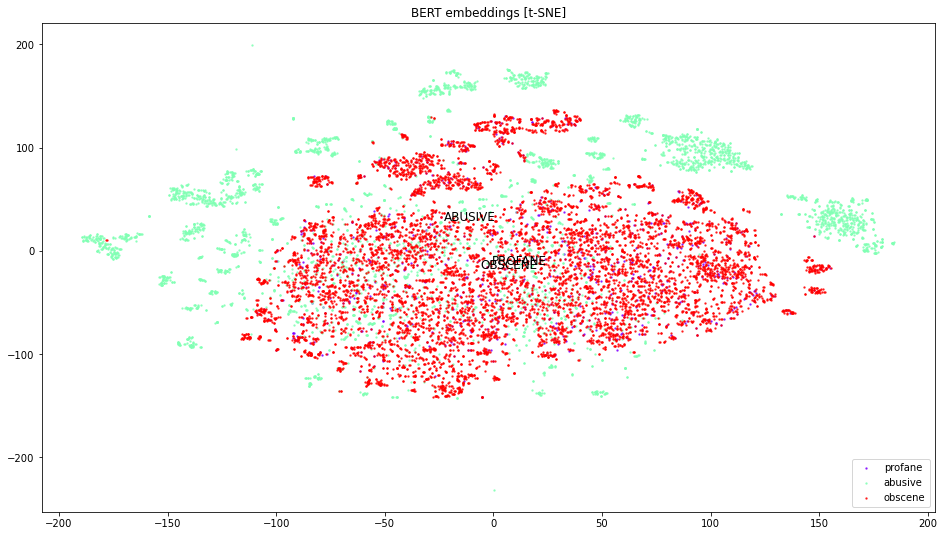

In [70]:
#idx = np.random.randint(0, 55000, 1000)
plotTSNE("BERT embeddings [t-SNE]", sentence_embeddings, labels, "test_thin.png")

In [71]:
colors = cm.rainbow(np.linspace(0, 1, len(set(labels))))
len(colors)

3

In [72]:
cm.tab20b(np.linspace(0, 1, len(set(labels))))

array([[0.22352941, 0.23137255, 0.4745098 , 1.        ],
       [0.90588235, 0.72941176, 0.32156863, 1.        ],
       [0.87058824, 0.61960784, 0.83921569, 1.        ]])